#Mount Drive

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing the required libraries


In [24]:
from collections import namedtuple
import torch
from torchvision import models
import torch.nn as nn
import argparse
import os
import sys
import time
import re
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import torch.onnx
from torch.autograd import Variable
from pycocotools.coco import COCO
from zipfile import ZipFile, BadZipFile
from PIL import Image

In [25]:
!apt-get install  git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


#Clone Git Repo

In [54]:
!rm -r Dashtoon_Style_Transfer

In [55]:
!git clone https://github.com/Rohan581/Dashtoon_Style_Transfer.git

Cloning into 'Dashtoon_Style_Transfer'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 51 (delta 8), reused 27 (delta 5), pack-reused 20
Receiving objects: 100% (51/51), 73.70 MiB | 30.54 MiB/s, done.
Resolving deltas: 100% (8/8), done.


#Extract features from VGG16 Model

In [28]:
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = models.vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return out

Some basic utilities that are going to be used further

In [29]:
def load_image(filename):
    img = Image.open(filename)
    return img

# assumes data comes in batch form (ch, h, w)
def save_image(filename, data):
    std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img = data.clone().numpy()
    img = ((img * std + mean).transpose(1, 2, 0)*255.0).clip(0, 255).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

# Calculate Gram matrix (G = FF^T)
def gram(x):
    (bs, ch, h, w) = x.size()
    f = x.view(bs, ch, w*h)
    f_T = f.transpose(1, 2)
    G = f.bmm(f_T) / (ch * h * w)
    return G

# using ImageNet values
def normalize_tensor_transform():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [30]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride) #, padding)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [31]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        out = self.relu(out)
        return out

In [32]:
class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample = nn.Upsample(scale_factor=upsample, mode='nearest')
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

#Implementing Image Transformation Network and Loss Network

In [33]:
class ImageTransformNet(nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()

        # nonlineraity
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        # encoding layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1_e = nn.InstanceNorm2d(32, affine=True)

        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2_e = nn.InstanceNorm2d(64, affine=True)

        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3_e = nn.InstanceNorm2d(128, affine=True)

        # residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        # decoding layers
        self.deconv3 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2 )
        self.in3_d = nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2 )
        self.in2_d = nn.InstanceNorm2d(32, affine=True)

        self.deconv1 = UpsampleConvLayer(32, 3, kernel_size=9, stride=1)
        self.in1_d = nn.InstanceNorm2d(3, affine=True)

    def forward(self, x):
        # encode
        y = self.relu(self.in1_e(self.conv1(x)))
        y = self.relu(self.in2_e(self.conv2(y)))
        y = self.relu(self.in3_e(self.conv3(y)))

        # residual layers
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)

        # decode
        y = self.relu(self.in3_d(self.deconv3(y)))
        y = self.relu(self.in2_d(self.deconv2(y)))
        y = self.tanh(self.in1_d(self.deconv1(y)))
        #y = self.deconv1(y)

        return y

Global hyperparameters

In [34]:
IMAGE_SIZE = 256
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
EPOCHS = 1
STYLE_WEIGHT = 1e4
CONTENT_WEIGHT = 1e0
TV_WEIGHT = 1e-7

#Downloading COCO Dataset

In [13]:
import os

coco_path = "./drive/MyDrive/coco"
zip_url_train = "http://images.cocodataset.org/zips/train2017.zip"
zip_url_val = "http://images.cocodataset.org/zips/val2017.zip"
zip_url_ann = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
zip_file_path_train = os.path.join(coco_path, "coco_train2017.zip")
zip_file_path_val = os.path.join(coco_path, "coco_val2017.zip")
zip_file_path_ann = os.path.join(coco_path, "coco_ann2017.zip")
# Check if the folder exists
if not os.path.exists(coco_path):
    print("Downloading coco dataset 2017...")
    os.makedirs(coco_path, exist_ok=True)
    os.system(f"wget {zip_url_train} -O {zip_file_path_train}")
    os.system(f"wget {zip_url_val} -O {zip_file_path_val}")
    os.system(f"wget {zip_url_ann} -O {zip_file_path_ann}")
else:
    print("Folder already exists. Skipping download.")

Folder already exists. Skipping download.


Extracting the dataset

In [35]:
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

In [36]:
# Extracting the coco dataset files

if not os.path.exists('./drive/MyDrive/coco/coco_train2017'):
    extract_zip_file("./drive/MyDrive/coco/coco_train2017")

if not os.path.exists('./drive/MyDrive/coco/coco_val2017'):
    extract_zip_file("./drive/MyDrive/coco/coco_val2017")

if not os.path.exists('./drive/MyDrive/coco/coco_ann2017'):
    extract_zip_file("./drive/MyDrive/coco/coco_ann2017")

Implementing a custom dataset

In [37]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


#Training on Style Image

In the train_args dictionary:

*   'style_image' takes the path where the style image on which we want to train is present.
*   'dataset' is the path of our coco dataset train images which we have stored on our drive.
*   'visualize' saves the output for every batch. To save use 1 otherwise 0.
*   'gpu' specifies whether we want to use GPU or not. To use a GPU use 1 otherwise 0.





In [62]:
train_args = {
    "style_image": "/content/Dashtoon_Style_Transfer/style_imgs/Mona_Lisa.jpg",
    "dataset": "/content/drive/MyDrive/coco/coco_train2017/train2017/",
    "visualize": 1,
    "gpu": 1
}

The train function takes the arguments and uses them to train the Image Transformation Network and minimise Content loss and Style loss and will save the style model.

In [43]:
def train(args):
    if (args['gpu'] == 1 and torch.cuda.is_available()):
      device="gpu"
      use_cuda = True
      dtype = torch.cuda.FloatTensor
      #torch.cuda.set_device(args['gpu'])
      print("Current device: %d" %torch.cuda.current_device())
    else:
      dtype = torch.FloatTensor
      device="cpu"

    # visualization of training controlled by flag
    visualize = (args['visualize'] != None)
    if (visualize):
        img_transform_512 = transforms.Compose([
            transforms.Resize(512),                  # scale shortest side to image_size
            transforms.CenterCrop(512),             # crop center image_size out
            transforms.ToTensor(),                  # turn image from [0-255] to [0-1]
            normalize_tensor_transform()      # normalize with ImageNet values
        ])

        testImage_amber = load_image("/content/Dashtoon_Style_Transfer/content_imgs/amber.jpg")
        testImage_amber = img_transform_512(testImage_amber)
        testImage_amber = Variable(testImage_amber.repeat(1, 1, 1, 1), requires_grad=False).type(dtype)

        testImage_maine = load_image("/content/Dashtoon_Style_Transfer/content_imgs/maine.jpg")
        testImage_maine = img_transform_512(testImage_maine)
        testImage_maine = Variable(testImage_maine.repeat(1, 1, 1, 1), requires_grad=False).type(dtype)

    # define network
    image_transformer = ImageTransformNet().type(dtype)
    optimizer = Adam(image_transformer.parameters(), LEARNING_RATE)

    loss_mse = torch.nn.MSELoss()

    # load vgg network
    vgg = Vgg16().type(dtype)

    # get training dataset
    dataset_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),           # scale shortest side to image_size
        transforms.CenterCrop(IMAGE_SIZE),      # crop center image_size out
        transforms.ToTensor(),                 # turn image from [0-255] to [0-1]
        normalize_tensor_transform()      # normalize with ImageNet values
    ])
    train_dataset = ImageDataset(root_dir=train_args['dataset'], transform=dataset_transform)
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)



    # style image
    style_transform = transforms.Compose([
        transforms.ToTensor(),                  # turn image from [0-255] to [0-1]
        normalize_tensor_transform()      # normalize with ImageNet values
    ])
    style = load_image(args['style_image'])
    style = style_transform(style)
    style = Variable(style.repeat(BATCH_SIZE, 1, 1, 1)).type(dtype)
    style_name = os.path.split(args['style_image'])[-1].split('.')[0]

    # calculate gram matrices for style feature layer maps we care about
    style_features = vgg(style)
    style_gram = [gram(fmap) for fmap in style_features]

    for e in range(EPOCHS):

        # track values for...
        img_count = 0
        aggregate_style_loss = 0.0
        aggregate_content_loss = 0.0
        aggregate_tv_loss = 0.0

        # train network
        image_transformer.train()
        for batch_num, x in enumerate(train_loader):
            img_batch_read = len(x)
            img_count += img_batch_read

            # zero out gradients
            optimizer.zero_grad()

            # input batch to transformer network
            x = Variable(x).type(dtype)
            y_hat = image_transformer(x)

            # get vgg features
            y_c_features = vgg(x)
            y_hat_features = vgg(y_hat)

            # calculate style loss
            y_hat_gram = [gram(fmap) for fmap in y_hat_features]
            style_loss = 0.0
            for j in range(4):
                style_loss += loss_mse(y_hat_gram[j], style_gram[j][:img_batch_read])
            style_loss = STYLE_WEIGHT*style_loss
            aggregate_style_loss += style_loss.item()

            # calculate content loss (h_relu_2_2)
            recon = y_c_features[1]
            recon_hat = y_hat_features[1]
            content_loss = CONTENT_WEIGHT*loss_mse(recon_hat, recon)
            aggregate_content_loss += content_loss.data.item()

            # calculate total variation regularization (anisotropic version)
            # https://www.wikiwand.com/en/Total_variation_denoising
            diff_i = torch.sum(torch.abs(y_hat[:, :, :, 1:] - y_hat[:, :, :, :-1]))
            diff_j = torch.sum(torch.abs(y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]))
            tv_loss = TV_WEIGHT*(diff_i + diff_j)
            aggregate_tv_loss += tv_loss.item()

            # total loss
            total_loss = style_loss + content_loss + tv_loss

            # backprop
            total_loss.backward()
            optimizer.step()

            # print out status message
            if ((batch_num + 1) % 100 == 0):
                status = "{}  Epoch {}:  [{}/{}]  Batch:[{}]  agg_style: {:.6f}  agg_content: {:.6f}  agg_tv: {:.6f}  style: {:.6f}  content: {:.6f}  tv: {:.6f} ".format(
                                time.ctime(), e + 1, img_count, len(train_dataset), batch_num+1,
                                aggregate_style_loss/(batch_num+1.0), aggregate_content_loss/(batch_num+1.0), aggregate_tv_loss/(batch_num+1.0),
                                style_loss.item(), content_loss.item(), tv_loss.item()
                            )
                print(status)

            if ((batch_num + 1) % 1000 == 0) and (visualize):
                image_transformer.eval()

                if not os.path.exists("visualization"):
                    os.makedirs("visualization")
                if not os.path.exists("visualization/%s" %style_name):
                    os.makedirs("visualization/%s" %style_name)

                outputTestImage_amber = image_transformer(testImage_amber).cpu()
                amber_path = "visualization/%s/amber_%d_%05d.jpg" %(style_name, e+1, batch_num+1)
                save_image(amber_path, outputTestImage_amber.data[0])


                outputTestImage_maine = image_transformer(testImage_maine).cpu()
                maine_path = "visualization/%s/maine_%d_%05d.jpg" %(style_name, e+1, batch_num+1)
                save_image(maine_path, outputTestImage_maine.data[0])

                print("images saved")
                image_transformer.train()

    # save model
    # save model
    image_transformer.eval()

    if use_cuda:
        image_transformer.cpu()

    if not os.path.exists("models"):
        os.makedirs("models")
    filename = "models/" + str(style_name) + "_" + str(time.ctime()).replace(' ', '_') + ".model"
    torch.save(image_transformer.state_dict(), filename)

    if use_cuda:
        image_transformer.cuda()

In [40]:
train(train_args)

#Using Style Transfer

The 'style_args' dictionary will take the following arguments:



*   'model_path' is the path where the model from training is saved
*   'source' is the path of the image which needs to be styled
*   'output' is the path where styled images will be saved
*   'gpu' is whether GPU is to be used or not. To use a GPU use 1 otherwise 0.





In [56]:
folder_name = 'Output'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
style_args = {
    "model_path": "/content/Dashtoon_Style_Transfer/models/Mona_Lisa.model",
    "source": "/content/Dashtoon_Style_Transfer/content_imgs/maine.jpg",
    "output": "/content/Output/1.jpg",
    "gpu":1
}

In [60]:
def style_transfer(args):
    if (args['gpu'] == 1 and torch.cuda.is_available()):
      device="gpu"
      use_cuda = True
      dtype = torch.cuda.FloatTensor
      #torch.cuda.set_device(args['gpu'])
      print("Current device: %d" %torch.cuda.current_device())
    else:
      dtype = torch.FloatTensor
      device="cpu"
    # content image
    img_transform_512 = transforms.Compose([
            transforms.Resize(512),                  # scale shortest side to image_size
            transforms.CenterCrop(512),             # crop center image_size out
            transforms.ToTensor(),                  # turn image from [0-255] to [0-1]
            normalize_tensor_transform()      # normalize with ImageNet values
    ])

    dtype = torch.FloatTensor

    content = load_image(args['source'])
    content = img_transform_512(content)
    content = content.unsqueeze(0)
    content = Variable(content).type(dtype)

    # load style model
    model_dict = torch.load(args['model_path'])
    model_dict_clone = model_dict.copy()
    for key, value in model_dict_clone.items():
        if key.endswith(('running_mean', 'running_var')):
            del model_dict[key]
    style_model = ImageTransformNet().type(dtype)
    style_model.load_state_dict(model_dict,False)

    # process input image
    stylized = style_model(content).cpu()
    save_image(args['output'], stylized.data[0])
    size = (400,400)
    im1 = Image.open(args['source'])
    im1 = im1.resize(size)
    print("Content Image: ")
    display(im1)
    im2 = Image.open(train_args['style_image'])
    im2 = im2.resize(size)
    print("Style Image: ")
    display(im2)
    im = Image.open(args['output'])
    im = im.resize(size)
    print("Output Image: ")
    display(im)

Content Image: 


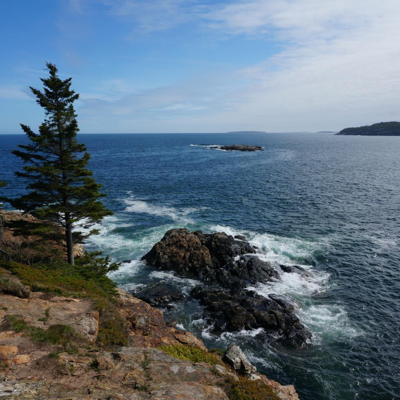

Style Image: 


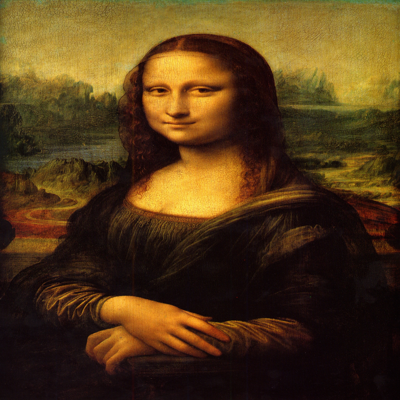

Output Image: 


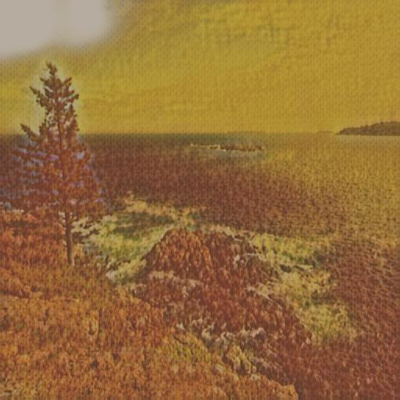

In [63]:
style_transfer(style_args)